Brusselator for exluded volume in 1D

In [57]:
import numpy as np
from scipy.fft import fftn, ifftn, fftfreq
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rc
import matplotlib.animation as animation
%matplotlib inline


def create_initial_array(num_of_nodes, ampl = 0.1):
        return (np.random.rand(num_of_nodes)-0.5) * ampl
    #return initial concentration of substance. Can be random, should be positive


class Brusselator():
    def __init__(self, N = 100, L = 10*np.pi, a=1.5, b=2.34, D0=2.8, D1=22.4, NUM_STEPS=10**4, dt = 0.005, c=10, method = 'pseudo-spectral'):
        self.N = N
        self.L = L
        self.a = a
        self.b = b
        self.D0 = D0
        self.D1 = D1
        self.NUM_STEPS = NUM_STEPS
        self.dt = dt
        self.c = c
        fu = lambda u,v: self.a + (u**2)*v - (self.b+1)*u
        fv = lambda u,v: self.b*u-(u**2)*v
        self.fu = fu
        self.fv = fv
        self.method = method
# code for initializing data, so that the same model can be run for different methods.
        base_state_u = self.a
        base_state_v = self.b/self.a
        # self.initial_data_u = create_initial_array(self.N)+base_state_u
        self.initial_data_u = create_initial_array(self.N)+base_state_u        
        self.initial_data_v = create_initial_array(self.N)+base_state_v

    def print_parameters(self):
        return f"Simulation for a={self.a},b={self.b},c={self.c} ,NUM_STEPS={self.NUM_STEPS},N={self.N}, D0={self.D0}, D1={self.D1}, dt = {self.dt}, L={self.L}"

In [58]:
def create_wavenumber_array(num_modes, L):
    # create array for wavenumbers in scipy format.
    num_modes = num_modes - num_modes%2 # make num of nodes even. Why?
    # this causes the program not to work for odd num_nodes
    # FIX THIS!
    wavenum_array = np.zeros(num_modes)
    wavenum = 2*np.pi/L
    p1 = np.array([(wavenum * i) for i in range(int(num_modes/2))])
    p2 = np.array([wavenum * (-num_modes+n) for n in range(int(num_modes/2), num_modes)])
    wavenum_array = np.concatenate((p1,p2))
    return wavenum_array

def create_time_operator(wavenums, diffusion_coeff, timestep):
    ## create a time evolution operator
    wavenums = wavenums**2
    return np.exp(-(wavenums)*timestep*diffusion_coeff)
def apply_step_fourier(u,operator):
        fft_u = fftn(u)
        fft_u = fft_u*operator
        return ifftn(fft_u).real

## Von Neumann boundary conditions
# # def apply_boundary_condition(Z):
#     Z[1] = Z[0]
#     Z[-2] Z[-1]
#     return Z
#     return Z
def periodic_boundary(Z):
     Z[0]= Z[-1]
     return Z
def nonlinear_step(u_main, v, c, wavenums):
    u = u_main
    R = c-u-v
    mu = -np.log(R)
    ## first derivative
    mu = 1j*wavenums*fftn(mu)
    mu = u*ifftn(mu).real
    ## second derivative
    mu = 1j*wavenums*fftn(mu)
    mu = ifftn(mu).real
    return mu

     

In [59]:
def perform_simulation(brusselator_class = Brusselator(), save_full = False):
    a, b, D0, D1 = brusselator_class.a, brusselator_class.b, brusselator_class.D0, brusselator_class.D1
    N, L, NUM_STEPS, dt = brusselator_class.N, brusselator_class.L, brusselator_class.NUM_STEPS, brusselator_class.dt
    method, fu, fv = brusselator_class.method, brusselator_class.fu, brusselator_class.fv
    dx = L / N
    savetimes = [0, NUM_STEPS//2, NUM_STEPS-2]
    c = brusselator_class.c

    initial_data_u = brusselator_class.initial_data_u
    initial_data_v = brusselator_class.initial_data_v

    wavenums = create_wavenumber_array(N, L)

    operator_u = create_time_operator(wavenums, D0, dt)
    operator_v = create_time_operator(wavenums, D1, dt)

##initialize data
    u = initial_data_u.copy()
    v = initial_data_v.copy()

    u_saved = []
    v_saved = []
    if save_full == True:
        time = np.empty(NUM_STEPS)
        time[0] = 0
        shape = time.shape+initial_data_u.shape
        conc_u = np.empty(shape)
        conc_v = np.empty(shape)

    for i in range(NUM_STEPS-1):
        if save_full == True:
            conc_u[i] = u.copy()
            conc_v[i] = v.copy()
            time[i] = i*dt

        if save_full == False:
            if i in savetimes:
                u_saved.append(u.copy())
                v_saved.append(v.copy())

## checking progress
        k = 100
        if i%k == 0:
            progress = float(i/NUM_STEPS)
            print(f"Progress: {progress}", end='\r', flush=True)

        if method == 'pseudo-spectral':
            nonlin_u = u + (D0*nonlinear_step(u, v, c, wavenums)+fu(u,v))*dt
            nonlin_v = v + (D1*nonlinear_step(v, u, c, wavenums)+fv(u,v))*dt
            u = apply_step_fourier(nonlin_u, operator_u)
            v = apply_step_fourier(nonlin_v, operator_v)

            ## periodic boundary conditions
            u[0]=u[-1]
            v[0]=v[-1]

    if save_full == True:
        return time, conc_u, conc_v
    else:
        return u_saved, v_saved


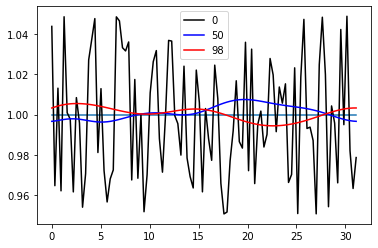

In [60]:
### 1D ###
br = Brusselator(a=1,b= 2,c=10, D0=1, D1=1, N=200 ,NUM_STEPS=10**3)
L = br.L
N = br.N
u,v= perform_simulation(br)
type(u)
time=[0,N//2,N-2]
xs = np.arange(0.0,L,L/N)
# Plot u(x) for different time points
color=['black','blue','red']
fig = plt.figure()
ax1 = fig.add_subplot(111)
indices=[0, 1, 2]
ax1.plot(xs,br.a *np.ones((100,1)))
for i in indices:
    ax1.plot(xs, u[i], label = time[i], c=color[i])
ax1.legend()
# ax1.legend()

plt.show()
# br.print_parameters()

In [61]:
## Plot u(x,y) as animation (2D)
time, u, v = perform_simulation(br, save_full=True)
## less data to show
xs = np.arange(0.0,L,L/N)

fig  = plt.figure()
ax   = plt.subplot(111)
i=0

def animate(i):
    ax.cla()
    fond = ax.plot(xs,u[i])
    return fond

anim = animation.FuncAnimation(fig, animate, frames=range(u.shape[0]), interval=100, repeat_delay=1000)
rc('animation', html='jshtml')

plt.close(anim._fig)
HTML(anim.to_jshtml())


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7f6264cf6b00>
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/transforms.py", line 222, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 
